# Convert NMSIM grid results *(.tig)* to raster *(.TIF)*

We will use the library `xarray` as a means to store 4D acoustic information.

In [1]:
# ==============  import libraries  =================

import xarray as xr
import numpy as np
import pandas as pd
from scipy import interpolate
import itertools
import matplotlib.pyplot as plt
import re
import os
import gdal
import osr
from tqdm.notebook import tqdm # a very helpful progress bar

# ==============  define functions  =================

def formatThirdOctave(raw_df):
    
    '''
    Format raw chunks of SPL data from a (.tig) file into a `numpy` array; 
    we use `pandas` as a "stepping stone" to make this much easier.
    '''
    
    # split each row of the raw data on whitespace
    arr = np.array([t.str.split(r"\s+")[0] for _, t in raw_df.iterrows()]) 

    # convert 2D array to dataframe, and change dtype from object to numeric
    third = pd.DataFrame(arr).apply(pd.to_numeric, errors='coerce')  

    # use the sequence column as an index instead
    third = third.set_index(third.columns[0], drop=True) 

    # remove the last column (which comes from the newline character at the end of each row)
    third = third.drop(third.columns[-1], axis=1) 

    # where applicable, convert from centibels to decibels (and d-prime to decimal)
    third.loc[:, 2:] = third.loc[:, 2:]/10 

    third[third == -99.9] = np.nan # use NaN for no data cells

    return third.values


def LAx(results, x=10):
    
    '''
    Return exceedance level LAx,* i.e., "the level exceeded x% of the time",
    and the "*"" indicates an undefined integration time (in our case, it should
    usually be about 1-2 seconds.)
    '''
    
    # convert exceedance to quantile
    q = (100 - x)/100
    
    values = results.loc[:,:,'LAeq'].astype('float').quantile(q, dim="timeStep")
    
    # it's necessary to replace np.nan for 'cubic' interpolation
    # unfortunately this affects the interpolation results (minorly)
    # so we'll use the minimum value already existing in the array 
    min_existing = values[~np.isnan(values)].min().values
    values = np.nan_to_num(values, nan=min_existing) 
    
    percentile = "{0:.0f}th percentile".format(100 - x)
    
    # also include a few metadata on this metric
    meta = {'full': percentile+" $LA_{eq,*}$",
            'alias': "LA"+"{0:.0f}".format(x),
            'unit': "dB"}
    
    return values, meta


def LTx(results, x=10):
    
    '''
    Return exceedance level LTx,* i.e., "the level exceeded x% of the time",
    and the "*" indicates an undefined integration time (in our case, it should
    be close to one second. Or... then again, maybe two.)
    
    The 'T' stands for 'truncated' or 'traffic'; it is the band from 12.5 - 1250 Hz.
    
    '''

    # select levels in the truncated (or 'traffic') bands; convert to [relative] pressures
    pressures = np.power(10, results.loc[:,:,"12.5":"1250"].astype('float')/10)
     
    # sum across bands; convert back to levels
    levels = 10*np.log10(pressures.sum(dim="thirdOct"))
    
    # lots of -inf; set to a very small pressure, instead
    levels = np.nan_to_num(levels, neginf=-99.9) 
    
    # convert exceedance to quantile
    q = 100 - x
    
    # we already have the truncated sum; now take the appropriate quantile in the time dimension
    values = np.nanpercentile(levels.astype('float'), q, axis=1)
    
    # it's necessary to replace np.nan for 'cubic' interpolation
    # unfortunately this affects the interpolation results (minorly)
    # so we'll use the minimum value already existing in the array 
    min_existing = values[~np.isnan(values)].min()
    values = np.nan_to_num(values, nan=min_existing, neginf=min_existing)
    
    percentile = "{0:.0f}th percentile".format(100 - x)
    
    # also include a few metadata on this metric
    meta = {'full': percentile+" $LT_{eq,*}$",
            'alias': "LT"+"{0:.0f}".format(x),
            'unit': "dB"}
    
    return values, meta


def TimeAbove(results, threshold=35.0, return_as_time=True):
    
    '''
    Tabulate the time equal-to or exceeding a sound level threshold for each grid reciever point.
    
    
    Inputs
    ------
    results: (xarray object) 3D DataArray containing .tig results
    
    threshold: (float) a sound level threshold
    
    return_as_time: (bool) if True - return the absolute amount of time above the threshold, in seconds; 
                           if False - return the percentage of the model duration above the threshold
                           
    Returns
    -------
    [if `return_as_time` is True] TimeAbove: (numpy array) duration above threshold for each grid cell (in seconds)
    [if `return_as_time` is False] pTimeAbove: (numpy array) percentage of total duration 
                                                             above threshold for each grid cell
    
    '''
    
    # we'll work with LAeq, here
    values = results.loc[:,:,'LAeq'].astype('float')
    
    # each time step during the model is slightly different (annoying but true)
    timeStepDurations = np.diff(results.loc[:,:,"time_s"])
    
    # total duration for each grid site (should be nearly identical)
    timeStepTotals = np.sum(timeStepDurations, axis=1)
    
    # for each cell in the matrix, return a boolean mask of threshold exceedance
    above_bools = (values >= threshold)[:, :-1]
    
    # the duration (in seconds) that the threshold was exceeded during the model run
    TimeAbove = np.array([np.sum(d[b]) for d, b in zip(timeStepDurations, above_bools)]) 
        
    if(return_as_time):
        
        # also include a few metadata on this metric
        meta = {'full': "Time Above $LA_{eq,*} =$" + " {0:.1f} dB".format(threshold),
                'alias': "TA"+"{0:.0f}".format(threshold),
                'unit': "Time Above (seconds)"}

        return TimeAbove, meta

    else:
        
        # also include a few metadata on this metric
        meta = {'full': "Time Above $LA_{eq,*} =$" + " {0:.1f} dB".format(threshold),
                'alias': "TA"+"{0:.0f}_percent".format(threshold),
                'unit': "Time Above (% of event duration)"}
        
        # percentage: time above over total time
        pTimeAbove = 100*TimeAbove/timeStepTotals
        
        return pTimeAbove, meta

    
def SEL(results):
    
    '''
    Tabulate the Sound Exposure Level (SEL) for each grid cell. SEL is a way of measuring 
    the overall 'noise dose' at a location.
    
    '''
    
    # we'll work with LAeq
    # ...and, because we use time differencing, we need to drop the last value
    values = results.loc[:,:,'LAeq'].astype('float')[:,:-1]

    # each time step during the model is slightly different (annoying but true)
    timeStepDurations = np.diff(results.loc[:,:,"time_s"])
    
    # compute the Sound Exposure Level (SEL) for each point
    SEL = 10*np.log10(np.sum(timeStepDurations*np.power(10, values/10), axis=1).astype('float'))

    # it's necessary to replace -inf for 'cubic' interpolation
    # unfortunately this affects the interpolation results (minorly)
    # so we'll use the minimum value already existing in the array 
    min_existing = SEL[~np.isnan(SEL) & np.isfinite(SEL)].min()
    SEL = np.nan_to_num(SEL, nan=min_existing, neginf=min_existing)
    
    # also include a few metadata on this metric
    meta = {'full': "Sound Exposure Level",
            'alias': "SEL",
            'unit': "dB"}

    return SEL, meta

## [Step 1] where is the NMSIM grid result *(.tig)* you'd like to process?

#### <font color=salmon size=4>You must edit this cell.</font>

In [2]:
tig = r"V:\NMSIM_Alpha_Tests_AH\NMSIM_to_TRJ_Test\CANYTEST\Output_Data\TIG_TIS\CANYTEST_C207_1200ft_AGL_120X120.tig"
# tig = r"C:\Users\DBetchkal\Desktop\NMSIM_2014_local\Data\DENARUTH\Output_Data\TIG_TIS\N72395_20190608_092241_120x120.tig"
# tig = r"C:\Users\DBetchkal\Desktop\NMSIM_2014_local\Data\DENACNTW\Output_Data\TIG_TIS\HeavyTruck_ParksHwy_65mph_4ftAGL_40RH_neg20F_1s_120x120.tig"
# tig = r"C:\Users\DBetchkal\Desktop\NMSIM_2014_local\Data\BAND002\Output_Data\TIG_TIS\C185_SR_W1_2600ft.tig"
# tig = r"C:\Users\DBetchkal\Desktop\NMSIM_2014_local\Data\DENATRLA\Output_Data\TIG_TIS\N74PS_20190630_005352_INRTakeoff.tig"

## [Step 2] Pre-digest the (.tig) file to determine the data bounds

This is relies heavily on Damon Joyce's R function `ConvertTIG2RDATA`, lines 18 - 59. 


In [3]:
with open(tig) as f:

    # we'll iterate through each line...
    sites = []  # ...gleaning the UTM coordinates
    site_rows = np.array([]) # ...gleaning the location of every site header
    
    for i, line in enumerate(f):

        if(re.findall("---End File Header---", line)):

            # the file header only occurs once; we want to know where this block ends
            fileHeaderLen = i

        elif(re.findall("Site:", line)):

            # site rows occur repeatedly; document each occurrence
            site_rows = np.append(site_rows, i)

        elif(re.findall(r"^UTM", line)):

            # glean the UTM zone that NMSIM used
            UTM_zone = int(line.split(r"  ")[1])

            # glean the UTM coordinates for the site 
            # and append them to the list as an (x, y) pair
            sites.append([int(line[27:33]), int(line[48:55])])


    # convert the list-of-lists to a numpy array
    sites = np.array(sites)

# how big is each data block?
chunk_len = np.diff(site_rows)[0] - 10

# tabulate all header rows; when loading the whole file we'll tell pandas to skip these
fileHeaderRows = np.arange(0, fileHeaderLen + 1, dtype="int")
siteHeaderRows = np.array([np.arange(s - 1, s + 9, 1) for s in site_rows], dtype="int")

# these are all the non-SPL rows
rowsToSkip = np.append(fileHeaderRows, siteHeaderRows)

##### An (optional) diagnostic plot showing each 'reciver site'

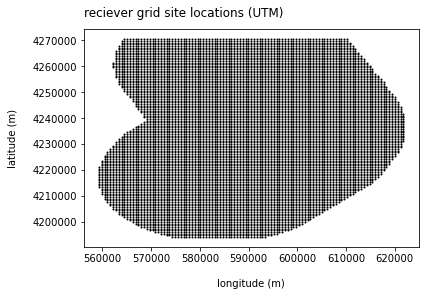

In [4]:
plt.plot(sites.T[0], sites.T[1], ls="", marker="o", color="k", ms=1)
plt.title("reciever grid site locations (UTM)", loc="left", y=1.03)

# for some reason matplotlib insists on converting large values to scientific notation
# this supresses default behavior
ax = plt.gca()
ax.ticklabel_format(style="plain")

plt.xlabel("longitude (m)", labelpad=15)
plt.ylabel("latitude (m)", labelpad=15)
plt.show()

## [Step 3] Read the data and organize into a 3D `xarray` object 😊 

Technically the original data are **4D**: an $(x, y)$ spatial matrix of $(t, f)$ pressure matrices. <br><br>
We map two spatial dimensions to a single site index $(x, y) \rightarrow j$. Axis label:  `site`. <br>
Because the exact timing at each point is subtly different, the second axis is labelled: `timeStep`. <br>
The third axis is frequency in one-third octave bands, labelled: `thirdOct`

In [6]:
# Read SPL data from the .tig as chunks
# (...unfortunately they'll come in as a single column. UGLY.)
dfs = pd.read_csv(tig, 
                  header=None,
                  skiprows=rowsToSkip,
                  skipinitialspace=True,
                  chunksize=chunk_len)

# So we format SPL data for each site into a 3D numpy array
# all values in the array must be of the same dtype, so we'll use "object"
# (It's S L O W: a `tqdm` progress bar is implemented as a courtesy...)
SPL_data = np.array([formatThirdOctave(chunk) for chunk in tqdm(dfs, total=len(sites))][:-1],
                    dtype="object")

# dim_0 corresponds to each site number [label: "site"]
items = np.arange(1, SPL_data.shape[0]+1)

# dim_1 (major axis) corresponds to the time steps [label: "timeStep"]
major_axis = np.arange(1, SPL_data.shape[1]+1)

# dim_2 (minor_axis) corresponds to the following columns [label: "thirdOct"]
minor_axis = ["time_s", "Leq", "LAeq", "10", "12.5", "15.8", "20", "25", "31.5",
                   "40", "50", "63", "80", "100", "125", "160", "200", "250", "315",
                   "400", "500", "630", "800", "1000", "1250", "1600", "2000", "2500",
                   "3150", "4000", "5000", "6300", "8000", "10000", "12500", "d'"]

# create the xarray object
results = xr.DataArray(SPL_data, [items, major_axis, minor_axis], 
                       dims=["site","timeStep","thirdOct"])

## [Step 4] Compute acoustic metrics from the `xarray` object
<font size=3>These will result in a **2D** matrix $(x, y)$ representing the metric at each reciever point.</font>

*(Again, this often relies on Damon's original work in R.)*

#### <font color=salmon size=4>You must edit this cell.</font>


In [17]:
# values, meta = LAx(results, x=10)
# values, meta = LTx(results, x=90)
# values, meta = TimeAbove(results, threshold=52.0, return_as_time=True)
values, meta = SEL(results)

C:\Users\DBetchkal\.conda\envs\geo\lib\site-packages\xarray\core\computation.py:724: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
C:\Users\DBetchkal\.conda\envs\geo\lib\site-packages\xarray\core\computation.py:724: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)


## [Step 5] save results as a raster *(.TIF)* using `gdal`

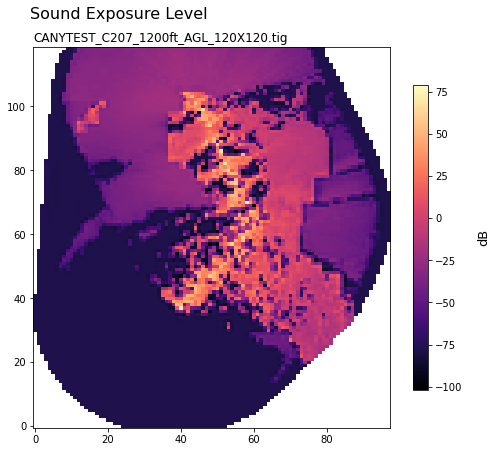

In [18]:
cell_size = np.percentile(np.diff(sites.T[1]), 50) # the typical difference in latitude
xmin, xmax = sites.T[0].min(), sites.T[0].max()
ymin, ymax = sites.T[1].min(), sites.T[1].max()

# here we compute the x and y steps necessary to make a grid of square cells
# (interpolation finer than 'site' spacing of the .tig is ill-advised; we'll approximate)
xsteps = np.ceil((xmax - xmin)/cell_size).astype('int')
ysteps = np.ceil((ymax - ymin)/cell_size).astype('int')

# then use the function `mgrid` to create new pairs of points 
# at each pair we will interpolate the expected value
xy_new = np.mgrid[xmin:xmax:complex(0, xsteps), 
                  ymin:ymax:complex(0, ysteps)].reshape(2,-1).T

# update the cell size for when we save out the raster (it'll be slightly different than the .tig)
cell_size_final = np.percentile([np.linalg.norm(xy_new[i+1] - xy_new[i]) for 
                                              i in np.arange(len(xy_new)-1)], 50)

# we can interpolate new values on a grid
# NOTE: 'cubic' would probably provide finer results, but the nan values cause problems
interpolated = interpolate.griddata(sites, values, xy_new, method='cubic')

# reshape interpolated values into a raster and re-orient
raster = np.reshape(interpolated, (xsteps, ysteps))
raster = np.flip(np.rot90(raster, k=3), axis=1)

# a preview of the results! handy
plt.figure(figsize=(8, 7))
plt.imshow(raster, origin="lower", aspect="auto", cmap="magma")
plt.suptitle(meta['full'], ha="left", fontsize=16, x=0.12, y=0.96)
plt.title(os.path.basename(tig), loc="left")
cb = plt.colorbar(shrink=0.8)
cb.set_label(meta['unit'], labelpad=15, fontsize=13)
# plt.savefig(r"C:\Users\DBetchkal\Desktop\N74PS_20190630_005352_INRTakeoff_" + meta['alias'] + "_.png",
#             dpi=150, bbox_inches="tight")
plt.show()

# epsg codes for UTM zones in the United States (haven't tested Hawaii yet!)
epsg_lookup = {1:'epsg:26901', 2:'epsg:26902', 3:'epsg:26903', 4:'epsg:26904', 5:'epsg:26905', 
               6:'epsg:26906', 7:'epsg:26907', 8:'epsg:26908', 9:'epsg:26909', 10:'epsg:26910', 
               11:'epsg:26911', 12:'epsg:26912', 13:'epsg:26913', 14:'epsg:26914', 15:'epsg:26915',
               16:'epsg:26916', 17:'epsg:26917'}

# look up the appropriate projection string
proj = epsg_lookup[UTM_zone]

# path to the output raster
out_path = tig[:-4] + "_" + meta['alias'] + ".TIF"

# write the raster to an array
driver = gdal.GetDriverByName('GTiff')
out = driver.Create(out_path, raster.shape[1], raster.shape[0], 1, gdal.GDT_Float32)
out.GetRasterBand(1).WriteArray(raster)

out.SetGeoTransform((xmin, cell_size_final, 0, ymin, 0, cell_size_final))
out.SetProjection(proj)
out.FlushCache()
out=None